<a href="https://colab.research.google.com/github/reiinakano/diff-painter/blob/master/notebooks/generate_stroke_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import sys
import os
from pathlib import Path

from PIL import Image
import numpy as np

sys.path.append('/root/mypaint')
sys.path.append('SPIRAL-tensorflow')
# import envs.mnist

from tqdm import tqdm
import tensorflow as tf
from PIL import Image, ImageDraw
from collections import defaultdict

from lib import surface, tiledsurface, brush
from mypaint_utils import *
import matplotlib.pyplot as plt

# Set up paint environment

In [2]:
class args:
  jump=True
  curve=True
  screen_size=64
  location_size=32
  color_channel=3
  brush_path='SPIRAL-tensorflow/assets/brushes/dry_brush.myb'
  data_dir=Path('data')

In [3]:
class PaintMode:
  STROKES_ONLY = 0
  JUMP_STROKES = 1
  CONNECTED_STROKES = 2

class ColorEnv():
    head = 0.25
    tail = 0.75
    
    # all 0 to 1
    actions_to_idx = {
        'pressure': 0,
        'size': 1,
        'control_x': 2,
        'control_y': 3,
        'end_x': 4,
        'end_y': 5,
        'color_r': 6,
        'color_g': 7,
        'color_b': 8,
        'start_x': 9,
        'start_y': 10,
        'entry_pressure': 11,
    }

    def __init__(self, args, paint_mode=PaintMode.JUMP_STROKES):
        self.args = args
        self.paint_mode = paint_mode

        # screen
        self.screen_size = args.screen_size
        self.height, self.width = self.screen_size, self.screen_size
        self.observation_shape = [
                self.height, self.width, args.color_channel]

        # location
        self.location_size = args.location_size
        self.location_shape = [self.location_size, self.location_size]
        
        self.prev_x, self.prev_y, self.prev_pressure = None, None, None
    
    @staticmethod
    def pretty_print_action(ac):
        for k, v in ColorEnv.actions_to_idx.items():
            print(k, ac[v])
    
    def random_action(self):
        return np.random.uniform(size=[len(self.actions_to_idx)])
      
    def reset(self):
        self.intermediate_images = []
        self.prev_x, self.prev_y, self.prev_pressure = None, None, None

        self.s = tiledsurface.Surface()
        self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
        self.s.begin_atomic()

        with open(self.args.brush_path) as fp:
            self.bi = brush.BrushInfo(fp.read())
        self.b = brush.Brush(self.bi)

    def draw(self, ac, s=None, dtime=1):
        # Just added this
        if self.paint_mode == PaintMode.STROKES_ONLY:
          self.s.clear()
          self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
          self.s.end_atomic()
          self.s.begin_atomic()
        
        if s is None:
            s = self.s

        s_x, s_y = ac[self.actions_to_idx['start_x']]*64, ac[self.actions_to_idx['start_y']]*64  
        e_x, e_y = ac[self.actions_to_idx['end_x']]*64, ac[self.actions_to_idx['end_y']]*64
        c_x, c_y = ac[self.actions_to_idx['control_x']]*64, ac[self.actions_to_idx['control_y']]*64
        color = (
            ac[self.actions_to_idx['color_r']],
            ac[self.actions_to_idx['color_g']],
            ac[self.actions_to_idx['color_b']],
        )
        pressure = ac[self.actions_to_idx['pressure']]*0.8
        entry_pressure = ac[self.actions_to_idx['entry_pressure']]*0.8
        size = ac[self.actions_to_idx['size']] * 2.
        
        if self.paint_mode == PaintMode.CONNECTED_STROKES:
            if self.prev_x is not None:
                s_x, s_y, entry_pressure = self.prev_x, self.prev_y, self.prev_pressure
            self.prev_x, self.prev_y, self.prev_pressure = e_x, e_y, pressure

        self.b.brushinfo.set_color_rgb(color)
        
        self.b.brushinfo.set_base_value('radius_logarithmic', size)

        # Move brush to starting point without leaving it on the canvas.
        self._stroke_to(s_x, s_y, 0)

        self._draw(s_x, s_y, e_x, e_y, c_x, c_y, entry_pressure, pressure, size, color, dtime)

    def _draw(self, s_x, s_y, e_x, e_y, c_x, c_y,
              entry_pressure, pressure, size, color, dtime):

        # if straight line or jump
        if pressure == 0:
            self.b.stroke_to(
                    self.s.backend, e_x, e_y, pressure, 0, 0, dtime)
        else:
            self.curve(c_x, c_y, s_x, s_y, e_x, e_y, entry_pressure, pressure)
            
        # Relieve brush pressure for next jump
        self._stroke_to(e_x, e_y, 0)

        self.s.end_atomic()
        self.s.begin_atomic()

    # sx, sy = starting point
    # ex, ey = end point
    # kx, ky = curve point from last line
    # lx, ly = last point from InteractionMode update
    def curve(self, cx, cy, sx, sy, ex, ey, entry_pressure, pressure):
        #entry_p, midpoint_p, junk, prange2, head, tail
        entry_p, midpoint_p, prange1, prange2, h, t = \
                self._line_settings(entry_pressure, pressure)

        points_in_curve = 100
        mx, my = midpoint(sx, sy, ex, ey)
        length, nx, ny = length_and_normal(mx, my, cx, cy)
        cx, cy = multiply_add(mx, my, nx, ny, length*2)
        x1, y1 = difference(sx, sy, cx, cy)
        x2, y2 = difference(cx, cy, ex, ey)
        head = points_in_curve * h
        head_range = int(head)+1
        tail = points_in_curve * t
        tail_range = int(tail)+1
        tail_length = points_in_curve - tail

        # Beginning
        px, py = point_on_curve_1(1, cx, cy, sx, sy, x1, y1, x2, y2)
        length, nx, ny = length_and_normal(sx, sy, px, py)
        bx, by = multiply_add(sx, sy, nx, ny, 0.25)
        self._stroke_to(bx, by, entry_p)
        pressure = abs(1/head * prange1 + entry_p)
        self._stroke_to(px, py, pressure)

        for i in xrange(2, head_range):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            pressure = abs(i/head * prange1 + entry_p)
            self._stroke_to(px, py, pressure)

        # Middle
        for i in xrange(head_range, tail_range):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            self._stroke_to(px, py, midpoint_p)

        # End
        for i in xrange(tail_range, points_in_curve+1):
            px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
            pressure = abs((i-tail)/tail_length * prange2 + midpoint_p)
            self._stroke_to(px, py, pressure)

        return pressure

    def _stroke_to(self, x, y, pressure, duration=0.1):
        self.b.stroke_to(
                self.s.backend,
                x, y,
                pressure,
                0.0, 0.0,
                duration)
        self.s.end_atomic()
        self.s.begin_atomic()
        self.intermediate_images.append(self.image)

    def save_image(self, path="test.png"):
        Image.fromarray(self.image.astype(np.uint8).squeeze()).save(path)
        #self.s.save_as_png(path, alpha=False)

    @property
    def image(self):
        rect = [0, 0, self.height, self.width]
        scanline_strips = \
                surface.scanline_strips_iter(self.s, rect)
        return next(scanline_strips)

    def _line_settings(self, entry_pressure, pressure):
        p1 = entry_pressure
        p2 = (entry_pressure + pressure) / 2
        p3 = pressure
        if self.head == 0.0001:
            p1 = p2
        prange1 = p2 - p1
        prange2 = p3 - p2
        return p1, p2, prange1, prange2, self.head, self.tail


## Sanity check paint environment

[Step 0] ac: [0.86564351 0.52084786 0.06288686 0.16110451 0.74375532 0.26481934
 0.13931493 0.08330324 0.81863896 0.1328736  0.94312761 0.04244152]
('end_y', 0.26481934469555124)
('end_x', 0.7437553241914193)
('color_g', 0.08330324296360325)
('color_b', 0.8186389625049009)
('pressure', 0.865643514907344)
('entry_pressure', 0.042441520525091314)
('color_r', 0.1393149287627944)
('size', 0.5208478613795536)
('control_y', 0.16110450578823077)
('control_x', 0.06288686462012061)
('start_x', 0.13287359682269373)
('start_y', 0.943127611959041)


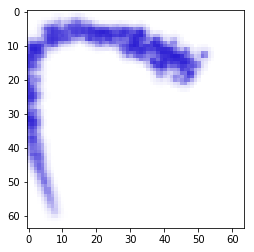

[Step 1] ac: [0.70973254 0.35746784 0.13201287 0.15422176 0.04306447 0.39482764
 0.27346406 0.23885423 0.22190351 0.23591713 0.02933697 0.55847382]
('end_y', 0.3948276429322636)
('end_x', 0.04306446662706975)
('color_g', 0.23885423151188745)
('color_b', 0.2219035050287933)
('pressure', 0.7097325432041063)
('entry_pressure', 0.5584738161343921)
('color_r', 0.27346405961510933)
('size', 0.35746784164246437)
('control_y', 0.15422175672474592)
('control_x', 0.13201287363582648)
('start_x', 0.2359171327854358)
('start_y', 0.029336973128628152)


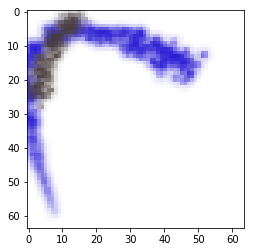

[Step 2] ac: [0.32082576 0.81722594 0.45797119 0.68511134 0.98999738 0.61068842
 0.62528416 0.54330573 0.38623985 0.97115602 0.2915558  0.78866383]
('end_y', 0.6106884209621787)
('end_x', 0.9899973832086976)
('color_g', 0.5433057291283644)
('color_b', 0.38623985410038675)
('pressure', 0.32082576107696026)
('entry_pressure', 0.7886638320944076)
('color_r', 0.6252841565598777)
('size', 0.8172259385128736)
('control_y', 0.6851113432166478)
('control_x', 0.4579711904065261)
('start_x', 0.9711560159191334)
('start_y', 0.29155580151977933)


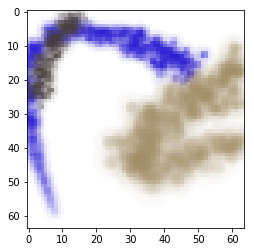

[Step 3] ac: [0.66450413 0.86321086 0.42366387 0.60941586 0.75014692 0.38921273
 0.76455198 0.29442052 0.61069072 0.43976915 0.81662296 0.60956387]
('end_y', 0.38921273301811277)
('end_x', 0.7501469236023438)
('color_g', 0.2944205243878153)
('color_b', 0.6106907209896266)
('pressure', 0.664504130580066)
('entry_pressure', 0.6095638711252084)
('color_r', 0.7645519777441133)
('size', 0.8632108561509082)
('control_y', 0.60941585822426)
('control_x', 0.42366387244456594)
('start_x', 0.4397691533855742)
('start_y', 0.8166229639418942)


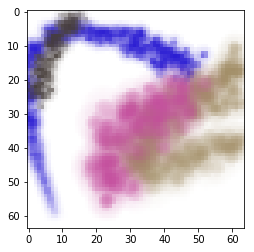

[Step 4] ac: [0.33191739 0.1686373  0.1077078  0.34266212 0.55130516 0.33205398
 0.56779361 0.18711832 0.11183537 0.85383702 0.87411675 0.53906529]
('end_y', 0.3320539783297898)
('end_x', 0.5513051551848988)
('color_g', 0.18711831517140998)
('color_b', 0.11183537208749772)
('pressure', 0.3319173893955697)
('entry_pressure', 0.5390652931841112)
('color_r', 0.5677936145425122)
('size', 0.16863730324349258)
('control_y', 0.34266212170448795)
('control_x', 0.10770780149327175)
('start_x', 0.8538370170597848)
('start_y', 0.8741167499630151)


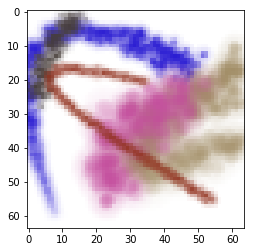

In [4]:
env=ColorEnv(args, paint_mode=PaintMode.JUMP_STROKES)

try:
  os.makedirs('data/generated')
except OSError:
  pass

for ep_idx in range(1):
    env.reset()

    for i in range(5):
        action = env.random_action()
        #action[env.actions_to_idx['color_r']] = 0.50
        #action[env.actions_to_idx['color_g']] = 0.2
        #action[env.actions_to_idx['color_b']] = 0.3
        print("[Step {}] ac: {}".format(i, action))
        ColorEnv.pretty_print_action(action)
        env.draw(action)
        plt.imshow(env.image)
        plt.show()
        env.save_image("data/generated/mnist{}_{}.png".format(ep_idx, i))

[Step 0] ac: [0.46733977 0.46510894 0.6491848  0.21298147 0.79613486 0.46234377
 0.27531264 0.22041635 0.15993751 0.37869318 0.78550818 0.01066823]
('end_y', 0.46234377341111954)
('end_x', 0.7961348596680681)
('color_g', 0.22041635168054519)
('color_b', 0.15993751330423422)
('pressure', 0.467339768244877)
('entry_pressure', 0.01066823111217885)
('color_r', 0.27531264145414025)
('size', 0.4651089383467497)
('control_y', 0.21298147387401944)
('control_x', 0.649184804451427)
('start_x', 0.37869318428139154)
('start_y', 0.7855081840814153)


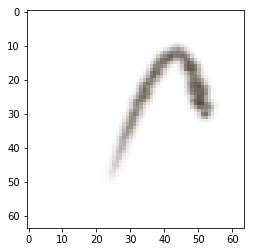

[Step 1] ac: [0.43212027 0.94891762 0.69372797 0.30973016 0.21753171 0.41100234
 0.34296122 0.63991189 0.28797118 0.7909065  0.00330646 0.31845702]
('end_y', 0.41100234124044877)
('end_x', 0.21753171022248985)
('color_g', 0.6399118886404876)
('color_b', 0.2879711828072664)
('pressure', 0.43212026961440386)
('entry_pressure', 0.31845701940261584)
('color_r', 0.3429612168938352)
('size', 0.9489176184169928)
('control_y', 0.3097301642422323)
('control_x', 0.6937279651103498)
('start_x', 0.7909064954272491)
('start_y', 0.0033064642555044044)


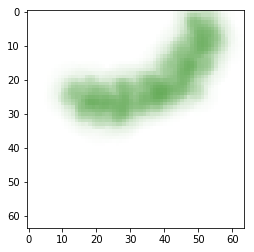

[Step 2] ac: [0.07678426 0.16018562 0.4533607  0.23017107 0.05594138 0.84132975
 0.77484365 0.33422464 0.06982186 0.16536036 0.70671301 0.73619452]
('end_y', 0.8413297513511382)
('end_x', 0.05594138219275113)
('color_g', 0.334224641587784)
('color_b', 0.06982186049265882)
('pressure', 0.07678425754126783)
('entry_pressure', 0.7361945155092068)
('color_r', 0.7748436500854881)
('size', 0.16018561685769117)
('control_y', 0.23017106675349652)
('control_x', 0.4533607046393714)
('start_x', 0.16536035733868493)
('start_y', 0.7067130064831738)


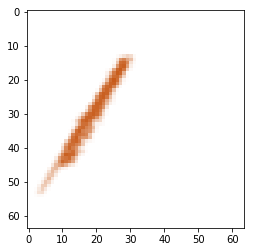

[Step 3] ac: [0.90166931 0.22858983 0.66350985 0.73572601 0.34867021 0.26276306
 0.53489802 0.36151854 0.39581203 0.05908109 0.16481913 0.02610958]
('end_y', 0.2627630623676158)
('end_x', 0.34867021422652056)
('color_g', 0.36151853996655336)
('color_b', 0.3958120309447952)
('pressure', 0.9016693076381135)
('entry_pressure', 0.026109576228496967)
('color_r', 0.5348980175184859)
('size', 0.22858982950136653)
('control_y', 0.7357260075638592)
('control_x', 0.6635098450160906)
('start_x', 0.05908108889261843)
('start_y', 0.1648191292386022)


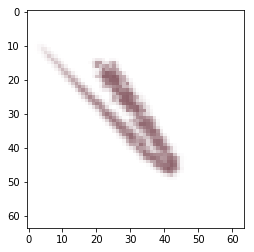

[Step 4] ac: [0.10798507 0.43248643 0.70489736 0.25341283 0.10822645 0.80638899
 0.14027219 0.98610793 0.01437918 0.15074299 0.8636929  0.77702719]
('end_y', 0.8063889942625468)
('end_x', 0.10822645336941783)
('color_g', 0.9861079250188513)
('color_b', 0.014379182815499991)
('pressure', 0.1079850690045181)
('entry_pressure', 0.777027193493735)
('color_r', 0.14027218570683309)
('size', 0.4324864268116685)
('control_y', 0.253412825573194)
('control_x', 0.7048973555351442)
('start_x', 0.15074299386552814)
('start_y', 0.8636929049352425)


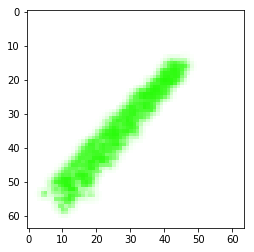

In [5]:
env=ColorEnv(args, paint_mode=PaintMode.STROKES_ONLY)

try:
  os.makedirs('data/generated')
except OSError:
  pass

for ep_idx in range(1):
    env.reset()

    for i in range(5):
        action = env.random_action()
        #action[env.actions_to_idx['color_r']] = 0.50
        #action[env.actions_to_idx['color_g']] = 0.2
        #action[env.actions_to_idx['color_b']] = 0.3
        print("[Step {}] ac: {}".format(i, action))
        ColorEnv.pretty_print_action(action)
        env.draw(action)
        plt.imshow(env.image)
        plt.show()
        env.save_image("data/generated/mnist{}_{}.png".format(ep_idx, i))

[Step 0] ac: [0.74385963 0.58587855 0.77283158 0.51767523 0.02002226 0.94489803
 0.90927064 0.13195985 0.27497408 0.91501542 0.23597776 0.        ]
('end_y', 0.9448980273614391)
('end_x', 0.02002225768389887)
('color_g', 0.13195984735503463)
('color_b', 0.27497408108937094)
('pressure', 0.7438596305364661)
('entry_pressure', 0.0)
('color_r', 0.9092706406525539)
('size', 0.5858785463216305)
('control_y', 0.5176752307459903)
('control_x', 0.7728315819867876)
('start_x', 0.9150154157376003)
('start_y', 0.23597775624004802)


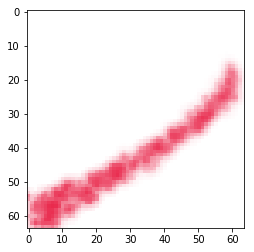

[Step 1] ac: [0.41648619 0.90008865 0.12303404 0.29597961 0.22161327 0.43168606
 0.61521456 0.14420808 0.96009966 0.66872753 0.25734645 0.        ]
('end_y', 0.4316860575650723)
('end_x', 0.2216132685999913)
('color_g', 0.144208078371025)
('color_b', 0.9600996587914501)
('pressure', 0.4164861857812532)
('entry_pressure', 0.0)
('color_r', 0.6152145608816139)
('size', 0.9000886489322335)
('control_y', 0.29597961375525195)
('control_x', 0.12303403771536581)
('start_x', 0.6687275277599346)
('start_y', 0.25734644687837815)


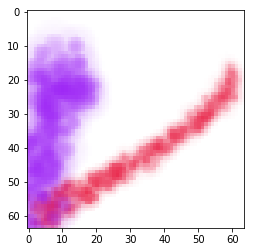

[Step 2] ac: [0.31480642 0.47068432 0.85357561 0.16699734 0.16054897 0.94086302
 0.04914496 0.24559531 0.11295047 0.56145633 0.24407684 0.        ]
('end_y', 0.9408630237029558)
('end_x', 0.16054897408398738)
('color_g', 0.24559530774682137)
('color_b', 0.11295046593582847)
('pressure', 0.31480642489087873)
('entry_pressure', 0.0)
('color_r', 0.049144960271883975)
('size', 0.47068432204263055)
('control_y', 0.16699733708590636)
('control_x', 0.8535756053510603)
('start_x', 0.5614563346635127)
('start_y', 0.24407683517158607)


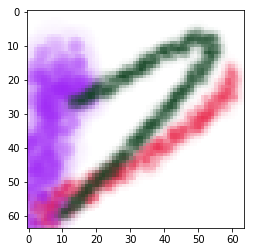

[Step 3] ac: [0.12996506 0.82048481 0.67886185 0.08893595 0.21406702 0.84486936
 0.2499129  0.78050283 0.72619757 0.29468232 0.36474656 0.        ]
('end_y', 0.8448693614985144)
('end_x', 0.21406701950266283)
('color_g', 0.7805028342938017)
('color_b', 0.7261975660847956)
('pressure', 0.12996505919121826)
('entry_pressure', 0.0)
('color_r', 0.24991289964127528)
('size', 0.8204848131343208)
('control_y', 0.08893594632247837)
('control_x', 0.678861853535674)
('start_x', 0.2946823190854352)
('start_y', 0.3647465559325155)


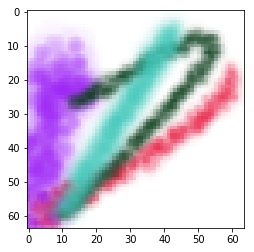

[Step 4] ac: [0.71846119 0.77444815 0.34028243 0.41650641 0.84666814 0.73605087
 0.1830439  0.98113948 0.40145915 0.44789923 0.84918121 0.        ]
('end_y', 0.7360508735656013)
('end_x', 0.8466681406769981)
('color_g', 0.9811394806489921)
('color_b', 0.4014591456402363)
('pressure', 0.718461186417019)
('entry_pressure', 0.0)
('color_r', 0.18304389743321714)
('size', 0.774448150226792)
('control_y', 0.41650640783026105)
('control_x', 0.3402824306690114)
('start_x', 0.44789923382458097)
('start_y', 0.8491812065152908)


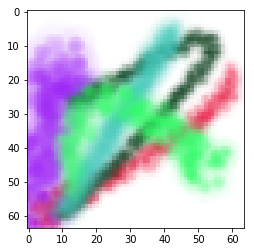

In [6]:
env=ColorEnv(args, paint_mode=PaintMode.CONNECTED_STROKES)

try:
  os.makedirs('data/generated')
except OSError:
  pass

for ep_idx in range(1):
    env.reset()

    for i in range(5):
        action = env.random_action()
        #action[env.actions_to_idx['color_r']] = 0.50
        #action[env.actions_to_idx['color_g']] = 0.2
        #action[env.actions_to_idx['color_b']] = 0.3
        action[env.actions_to_idx['entry_pressure']] = 0.
        print("[Step {}] ac: {}".format(i, action))
        ColorEnv.pretty_print_action(action)
        env.draw(action)
        plt.imshow(env.image)
        plt.show()
        env.save_image("data/generated/mnist{}_{}.png".format(ep_idx, i))

# Generate action to brushstroke image examples

This takes a long time. You might want to adjust the number of shards or change the Colab runtime to local or save directly to Google Drive to avoid losing progress.

Alternatively, just skip this step and download the strokes I generated.

In [7]:
%%time
env=ColorEnv(args, paint_mode=PaintMode.STROKES_ONLY)

NUM_SHARDS = 80
NUM_STROKES_PER_SHARD = 100000
SHARD_NUM_OFFSET = 0

for i in range(SHARD_NUM_OFFSET, SHARD_NUM_OFFSET+NUM_SHARDS):
    actions = []
    strokes = []
    for idx in range(NUM_STROKES_PER_SHARD):
        env.reset()
        if idx % 100 == 0:
            print "\rShard %d: %d out of (%d)" %(i, idx, NUM_STROKES_PER_SHARD),
        action = env.random_action()
        actions.append(action)
        env.draw(action)
        strokes.append(env.image[:, :, :3])
    actions = np.array(actions, dtype=np.float)
    strokes = np.array(strokes, dtype=np.uint8)
    np.savez_compressed("data/episodes_{}.npz".format(i), actions=actions, strokes=strokes)

Shard 79: 99900 out of (100000)CPU times: user 3d 11h 35min 45s, sys: 16min 20s, total: 3d 11h 52min 6s
Wall time: 14h 11min 53s



# Test out the generated files

In [8]:
loaded = np.load('data/episodes_0.npz')

In [9]:
print loaded['actions'].shape
print loaded['strokes'].shape


(100000, 12)
(100000, 64, 64, 3)


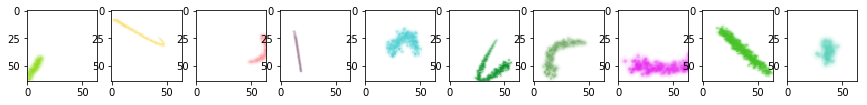

In [10]:
import matplotlib.pyplot as plt

w=args.screen_size
h=args.screen_size
fig=plt.figure(figsize=(30, 10))
cols = 10

smaller_arr = loaded['strokes'][:cols]

for col in range(cols):
    img = smaller_arr[col][:, :, :3]
    #print(img.shape)
    fig.add_subplot(1, 20, col+1)
    plt.grid(False)
    plt.imshow(img)
plt.show()

In [11]:
for ac in loaded['actions'][:cols]:
    print('___')
    ColorEnv.pretty_print_action(ac)

___
('end_y', 0.8838190689458792)
('end_x', 0.06802111804519273)
('color_g', 0.8446473593179583)
('color_b', 0.058491700536361435)
('pressure', 0.17280892070819553)
('entry_pressure', 0.37358074725881585)
('color_r', 0.5378408743136833)
('size', 0.698298977160147)
('control_y', 0.6788559962028722)
('control_x', 0.18677211981968256)
('start_x', 0.013925000181113978)
('start_y', 0.9696656957888448)
___
('end_y', 0.384472348453334)
('end_x', 0.6700000709883037)
('color_g', 0.8531691651296921)
('color_b', 0.35257819160487724)
('pressure', 0.18494097506237872)
('entry_pressure', 0.591695979393967)
('color_r', 0.9815523666688645)
('size', 0.08836062726742255)
('control_y', 0.47711259767724945)
('control_x', 0.6667791830305407)
('start_x', 0.04290319066403603)
('start_y', 0.12927191197366672)
___
('end_y', 0.3714992148129381)
('end_x', 0.9517698086045331)
('color_g', 0.40751793712931794)
('color_b', 0.42788371223412114)
('pressure', 0.3166162405786891)
('entry_pressure', 0.08825351353977418)


In [12]:
"""
env=ColorEnv(args, paint_mode=PaintMode.JUMP_STROKES)
#env2 = ColorEnv(args, paint_mode=PaintMode.JUMP_STROKES)

try:
  os.makedirs('data')
except OSError:
  pass

NUM_STROKES = 200000
NUM_SHARDS = 1
NUM_STROKES_PER_SHARD = NUM_STROKES/NUM_SHARDS

for i in range(NUM_SHARDS):
  env.reset()
  #env2.reset()
  actions = []
  strokes = []
  #full_images = []
  for idx in range(NUM_STROKES_PER_SHARD):
    if idx % 2000 == 0: print(idx)
    
    action = env.random_action()
    actions.append(action)
    env.draw(action)
    #env2.draw(action)
    strokes.append(env.image[:, :, :3])
    #full_images.append(env2.image[:, :, :3])
  actions = np.array(actions, dtype=np.float)
  strokes = np.array(strokes, dtype=np.uint8)
  #full_images = np.array(full_images, dtype=np.uint8)
  np.savez_compressed("data/full_strokes_{}.npz".format(i), actions=actions, strokes=strokes)
"""

'\n\nenv=ColorEnv(args, paint_mode=PaintMode.JUMP_STROKES)\n#env2 = ColorEnv(args, paint_mode=PaintMode.JUMP_STROKES)\n\ntry:\n  os.makedirs(\'data\')\nexcept OSError:\n  pass\n\nNUM_STROKES = 200000\nNUM_SHARDS = 1\nNUM_STROKES_PER_SHARD = NUM_STROKES/NUM_SHARDS\n\nfor i in range(NUM_SHARDS):\n  env.reset()\n  #env2.reset()\n  actions = []\n  strokes = []\n  #full_images = []\n  for idx in range(NUM_STROKES_PER_SHARD):\n    if idx % 2000 == 0: print(idx)\n    \n    action = env.random_action()\n    actions.append(action)\n    env.draw(action)\n    #env2.draw(action)\n    strokes.append(env.image[:, :, :3])\n    #full_images.append(env2.image[:, :, :3])\n  actions = np.array(actions, dtype=np.float)\n  strokes = np.array(strokes, dtype=np.uint8)\n  #full_images = np.array(full_images, dtype=np.uint8)\n  np.savez_compressed("data/full_strokes_{}.npz".format(i), actions=actions, strokes=strokes)\n'